In [1]:
import sys
sys.path.append('..') #to add top-level to path

import numpy as np
import pandas as pd
from modules.opts import black, imp_vol, delta, RatesCurve, FuturesCurve, VolCurve, find_delta
from modules.opts import CreateVolCurveSample, delta_moneyness
from dateutil.relativedelta import relativedelta
from numpy.polynomial.polynomial import polyval, polyfit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
futs = FuturesCurve()
futs.get('NQ','11/08/2019','09/10/2018')

8248.88461538

In [3]:
futs.get('ES','2019-8-5','1M')

2830.01758242

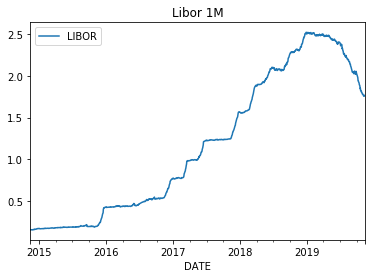

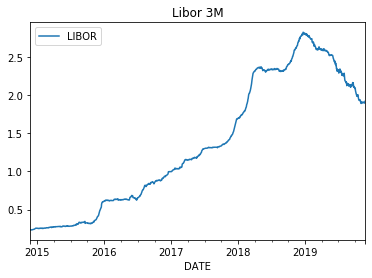

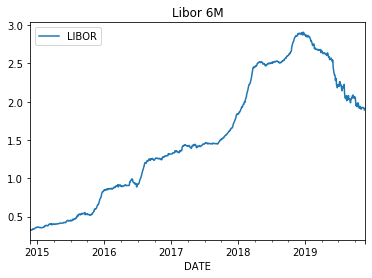

In [5]:
rates = RatesCurve()
rates.rates.plot(title = 'Libor 1M')
rates.rates_3m.plot(title = 'Libor 3M')
rates.rates_6m.plot(title = 'Libor 6M');

In [6]:
rates.get('2019-8-5')

2.2230000000000003

In [7]:
rates.get('2019-8-5', '2019-10-16')

2.211923076923077

In [8]:
black(20, 20, 0.25, 0.09, 4/12, 'call')

1.1166414565589438

In [9]:
imp_vol(1.1166,20, 20, 0.09, 4/12,'put')

0.24999070234162651

In [10]:
delta(20, 20, 0.25, 0.09, 4/12, opt_type='call')

0.5131388031882277

In [11]:
delta_moneyness(np.log(20/20), .25, 0.09, 4/12, opt_type='call')

0.5131388031882277

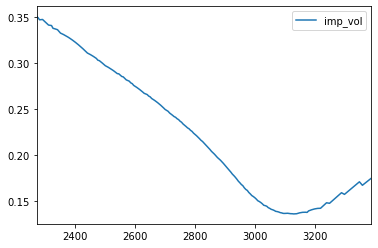

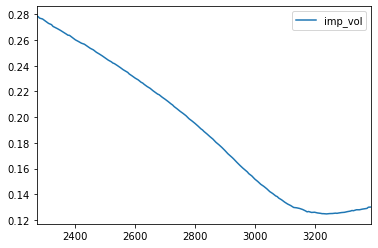

In [13]:
call_sep = '../data/intermediate_data/opt/ES-SEP-IMM-C-050819.csv'
call_dec ='../data/intermediate_data//opt/ES-DEC-IMM-C-050819.csv'
put_sep = '../data/intermediate_data//opt/ES-SEP-IMM-P-050819.csv'
put_dec = '../data/intermediate_data//opt/ES-DEC-IMM-P-050819.csv'
vcs = CreateVolCurveSample('ES','2019-8-5', call_sep, put_sep, call_dec, put_dec)
vcs.vol_curve['IMM1'].plot()
vcs.vol_curve['IMM2'].plot()

In [14]:
vcs.fut_prices

{'IMM1_call': 2830.0,
 'IMM2_call': 2830.5,
 'IMM1_put': 2830.0,
 'IMM2_put': 2830.5}

In [15]:
params_IMM1 = polyfit(np.log(vcs.vol_curve['IMM1'].index/vcs.fut_prices['IMM1_call']),vcs.vol_curve['IMM1'],5)

In [16]:
print('At the money volatility: ',params_IMM1[0])

At the money volatility:  [0.20797794]


In [17]:
vcs.expiration

{'IMM1_call': Timestamp('2019-09-20 00:00:00'),
 'IMM1_put': Timestamp('2019-09-20 00:00:00'),
 'IMM2_call': Timestamp('2019-12-20 00:00:00'),
 'IMM2_put': Timestamp('2019-12-20 00:00:00')}

In [18]:
t = (vcs.expiration['IMM1_call'] - vcs.today).days / 365
a1, b1 = find_delta(params_IMM1, 0.01*vcs.rate_curve.get('2019-8-5'),t , delta=0.25, opt_type='call')
a2, b2 = find_delta(params_IMM1, 0.01*vcs.rate_curve.get('2019-8-5'),t , delta=0.25, opt_type='put')
a3, b3 = find_delta(params_IMM1, 0.01*vcs.rate_curve.get('2019-8-5'),t , delta=0.5, opt_type='call')

In [19]:
print('50 delta strike: ',np.exp(a3) * vcs.fut_prices['IMM1_call'])
print('50 delta value implied vol: ',b3)
print('25 call delta strike: ',np.exp(a1) * vcs.fut_prices['IMM1_call'])
print('25 call delta value implied vol: ',b1)
print('25 put delta strike: ',np.exp(a2) * vcs.fut_prices['IMM1_call'])
print('25 put delta value implied vol: ',b2)

50 delta strike:  2836.8285631700664
50 delta value implied vol:  0.20572085859434172
25 call delta strike:  2952.5059077821475
25 call delta value implied vol:  0.16993741440394183
25 put delta strike:  2671.8247092106226
25 put delta value implied vol:  0.2586521141224441


In [20]:
params_IMM2 = polyfit(np.log(vcs.vol_curve['IMM2'].index/vcs.fut_prices['IMM2_call']),vcs.vol_curve['IMM2'],5)

In [21]:
IMM1_polyvals = polyval(np.log(np.arange(0.8,1.2,0.01)),params_IMM1)
IMM2_polyvals = polyval(np.log(np.arange(0.8,1.2,0.01)),params_IMM2)


In [22]:
t1 = (vcs.expiration['IMM1_call'] - vcs.today).days
t2 = (vcs.expiration['IMM2_call'] - vcs.today).days
vals_2M = (t2 - 61)/(t2-t1) * IMM1_polyvals + (61 - t1)/(t2-t1) * IMM2_polyvals
params_2M = polyfit(np.log(np.arange(0.8,1.2,0.01)),vals_2M.reshape(-1,1),5)


In [23]:
vc = VolCurve()

In [24]:
deltas_dict = {}
for inst in tqdm(['ES', 'NQ','C', 'W', 'S']):
    df = pd.DataFrame(index = vc.vol_poly_1M[inst].index, columns=['atm', 'd25_call', 'd25_put'])
    for date in vc.vol_poly_1M[inst].index:
        try:
            df.d25_call.loc[date] = find_delta(vc.vol_poly_1M[inst].loc[date],
                                               0.01*vc.rate_curve.get(date),1/12 )[1]
            df.d25_put.loc[date] = find_delta(vc.vol_poly_1M[inst].loc[date],
                                               0.01*vc.rate_curve.get(date),1/12, opt_type = 'put' )[1]
            df.atm.loc[date] = vc.vol_poly_1M[inst].loc[date][0]
        except RuntimeError:
            pass
        deltas_dict[inst] = df
    print(inst, deltas_dict[inst].isna().sum().sum())
        

 20%|██████████████████▊                                                                           | 1/5 [00:05<00:23,  5.88s/it]

ES 0


 40%|█████████████████████████████████████▌                                                        | 2/5 [00:11<00:17,  5.74s/it]

NQ 0


 60%|████████████████████████████████████████████████████████▍                                     | 3/5 [00:18<00:12,  6.17s/it]

C 0


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 4/5 [00:25<00:06,  6.44s/it]

W 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]

S 0


In [25]:
for inst in ['ES', 'NQ','C', 'W', 'S']:
    deltas_dict[inst]['rr25'] = deltas_dict[inst].d25_call - deltas_dict[inst].d25_put
    deltas_dict[inst]['fly25'] = (deltas_dict[inst].d25_call + 
                                 deltas_dict[inst].d25_put - deltas_dict[inst].d25_put)/2
    

In [26]:
deltas_dict['ES'].head()

,atm,d25_call,d25_put,rr25,fly25
Date,,,,,
2016-11-14,0.125389,0.106235,0.153201,-0.0469655,0.0531177
2016-11-15,0.115175,0.101731,0.139191,-0.0374605,0.0508654
2016-11-16,0.117945,0.102348,0.14233,-0.0399819,0.0511741
2016-11-17,0.114495,0.0993917,0.137302,-0.0379108,0.0496959
2016-11-18,0.11176,0.094488,0.132875,-0.0383871,0.047244


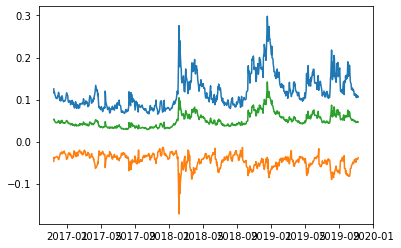

In [27]:
plt.plot(deltas_dict['ES'].atm)
plt.plot(deltas_dict['ES'].rr25)
plt.plot(deltas_dict['ES'].fly25)

In [28]:
params_2M

array([[  0.20461617],
       [ -0.88056515],
       [ -0.08536434],
       [ 17.67947559],
       [ 42.11481489],
       [-76.79533952]])

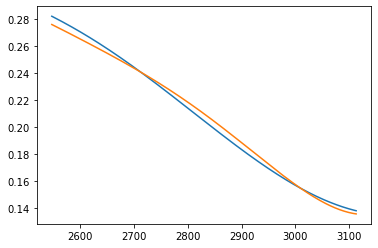

In [29]:
x = np.log(np.arange(0.9,1.1,0.001))
plt.plot(np.exp(x)*2830,polyval(x,params_2M).reshape(-1,1))
plt.plot(np.exp(x)*2830,polyval(x,VolCurve().vol_poly_2M['ES'].loc['2019-8-5']))

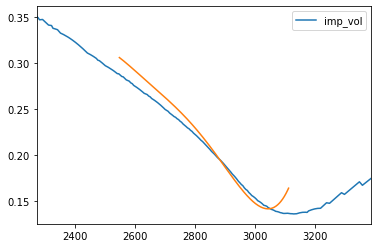

In [30]:
vcs.vol_curve['IMM1'].plot()
plt.plot(np.exp(x)*2830,polyval(x,VolCurve().vol_poly_1M['ES'].loc['2019-8-5']))

In [31]:
vc = VolCurve()
n = VolCurve().vol_poly_1M['ES'].loc['2019-8-5']
n.name + relativedelta(months=1)
r = vc.rate_curve.get(n.name)
mon, vol = find_delta(n, r, 1/12,delta=0.25,opt_type='put')

In [32]:
print(np.exp(mon)*2830, vol)

2731.417834994213 0.2530626953422069


In [33]:
VolCurve().vol_poly_1M['ES'].head()

,ES_1M_a0,ES_1M_a1,ES_1M_a2,ES_1M_a3,ES_1M_a4,ES_1M_a5
Date,,,,,,
2016-11-14,0.125389,-0.98149,1.10072,89.172,1212.08,5270.38
2016-11-15,0.115175,-0.828397,5.84525,107.234,256.24,-2667.22
2016-11-16,0.117945,-0.876455,3.1337,93.8511,842.575,2281.31
2016-11-17,0.114495,-0.860105,2.54365,93.9961,1043.3,3556.08
2016-11-18,0.11176,-0.923185,-2.51703,86.6023,2617.47,15773
